In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import seaborn as sns


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Chapter 18 examples

## 18.1 ,  Logistic

In [2]:
climbers = pd.read_csv("climbers.csv")
climbers.head()

,expedition_id,member_id,success,year,season,age,expedition_role,oxygen_used
0,AMAD81101,AMAD81101-03,True,1981,Spring,28,Climber,False
1,AMAD81101,AMAD81101-04,True,1981,Spring,27,Exp Doctor,False
2,AMAD81101,AMAD81101-02,True,1981,Spring,35,Deputy Leader,False
3,AMAD81101,AMAD81101-05,True,1981,Spring,37,Climber,False
4,AMAD81101,AMAD81101-06,True,1981,Spring,43,Climber,False


In [5]:

total = climbers.shape[0]
climbers[['success','member_id']].groupby('success').count().assign(percent = lambda x: x.member_id/total).rename(columns = {'member_id':'count'})

,count,percent
success,,
False,1269,0.611272
True,807,0.388728


In [8]:
climbers['expedition_id'].unique().shape[0] # how many expeditions?

200

<AxesSubplot:ylabel='Count'>

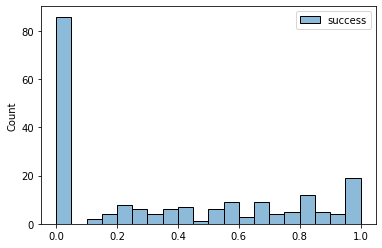

In [11]:
expedition_success = climbers[['expedition_id', 'success']].groupby('expedition_id').mean()
sns.histplot(data = expedition_success, binwidth=.05)

### Success by age and oxygen use

In [16]:
data_by_age_oxygen = climbers.groupby(['age','oxygen_used']).mean().reset_index().drop(columns='year')

<AxesSubplot:xlabel='age', ylabel='success'>

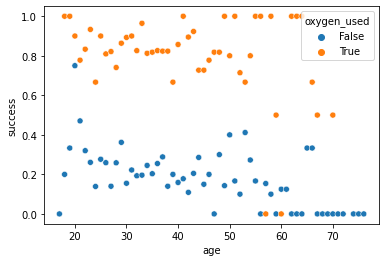

In [17]:
sns.scatterplot(data = data_by_age_oxygen, x= 'age', y='success', hue = 'oxygen_used')

Binomial model

In [18]:
model1 = bmb.Model('success ~ age + oxygen_used + (1|expedition_id)',data = climbers, family="bernoulli")
model1.build()
model1

Formula: success ~ age + oxygen_used + (1|expedition_id)
Family name: Bernoulli
Link: logit
Observations: 2076
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 9.3311)
    age ~ Normal(mu: 0.0, sigma: 0.2394)
    oxygen_used ~ Normal(mu: 0.0, sigma: 5.5123)

  Group-level effects
    1|expedition_id ~ Normal(mu: 0, sigma: HalfNormal(sigma: 9.3311))

In [ ]:
results = model1.fit()

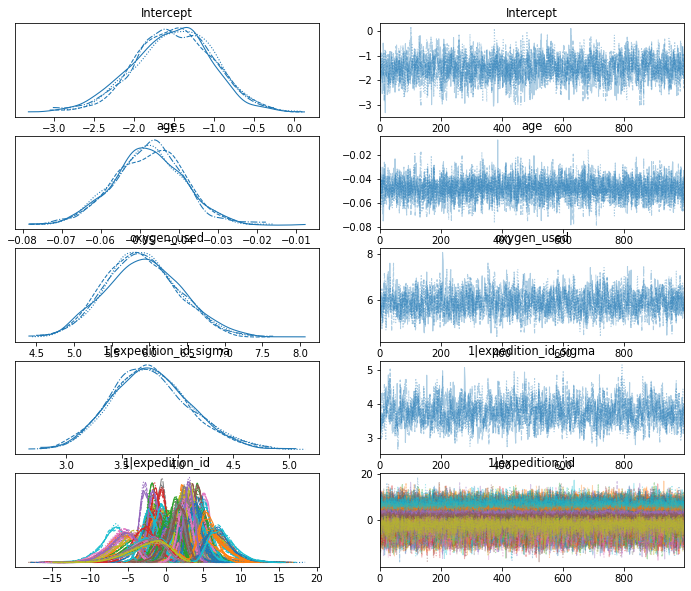

In [21]:
az.plot_trace(results,compact=True);

In [43]:
model1.predict(results,kind='pps')
post_pred = results.posterior_predictive.to_dataframe().reset_index()
post_df = results.posterior.to_dataframe().reset_index()

Each draw contains a prediction now for each of the climbers.  We can use this to manually check that the results make sense

<AxesSubplot:>

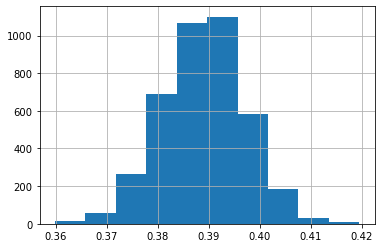

In [23]:
post_pred.groupby(['chain','draw']).mean()['success'].hist()

This is centered on the oberved success rate.
Now to look at the posterior values:


In [25]:
az.summary(results, hdi_prob=0.8).head(4)

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.503,0.491,-2.087,-0.844,0.015,0.011,1078.0,1571.0,1.01
age,-0.048,0.009,-0.059,-0.037,0.000,0.000,4356.0,3119.0,1.00
oxygen_used,5.911,0.493,5.223,6.492,0.013,0.009,1515.0,2006.0,1.00
1|expedition_id_sigma,3.765,0.356,3.295,4.202,0.012,0.008,935.0,1915.0,1.00


As text says, age coeffienct is signficant, as is oxygen used. . , improves odds by a factor 360 (mean)

In [26]:
np.exp(5.91)

368.706155409357

### Regression lines 

Now i want to plot plausible (median) regression lines, using draws for intercept and slope. Here we want to just plot the medians.

Generate 100 samples:

In [94]:
lines = post_df.query('expedition_id__factor_dim =="AMAD03107"')[['Intercept','age','oxygen_used']].sample(50,axis=0).reset_index(drop=True)
lines.head()

,Intercept,age,oxygen_used
0,-0.848944,-0.064567,5.875323
1,-0.669372,-0.052901,6.110749
2,-1.329050,-0.047603,6.252493
3,-1.016971,-0.053619,4.952478
4,-1.739879,-0.051480,6.058126


In [95]:
data_to_plot = pd.DataFrame()
# is this defined somewhere?
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

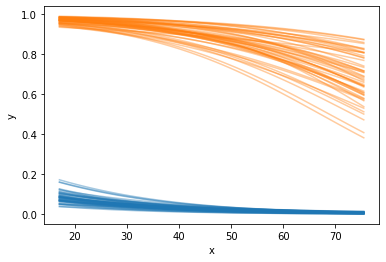

In [96]:
fig, ax = plt.subplots()
data_to_plot['x'] =np.tile(np.arange(climbers['age'].min(), climbers['age'].max(),.5),2)
nrows = len(data_to_plot)
data_to_plot['oxygen_used'] = np.concatenate([np.repeat(1,nrows/2 ),np.repeat(0,nrows/2)])

for (i,row) in lines.iterrows():
    data_to_plot['y_logit'] = row.Intercept + row.age * data_to_plot.x + row.oxygen_used*data_to_plot.oxygen_used
    data_to_plot['y'] = inv_logit(data_to_plot['y_logit'])
    sns.lineplot(data= data_to_plot, x = 'x', y= 'y', hue='oxygen_used', ax= ax, legend=False, alpha  =0.4)


### Accuracy

Lets add the predicted probabilty for each climber. 

In [40]:
climbers['pred_prob'] = post_pred.groupby('success_dim_0').mean()['success']
climbers.head()

,expedition_id,member_id,success,year,season,age,expedition_role,oxygen_used,pred_prob
0,AMAD81101,AMAD81101-03,True,1981,Spring,28,Climber,False,0.83050
1,AMAD81101,AMAD81101-04,True,1981,Spring,27,Exp Doctor,False,0.84325
2,AMAD81101,AMAD81101-02,True,1981,Spring,35,Deputy Leader,False,0.78075
3,AMAD81101,AMAD81101-05,True,1981,Spring,37,Climber,False,0.78825
4,AMAD81101,AMAD81101-06,True,1981,Spring,43,Climber,False,0.73375


Accuracy?

In [76]:
climbers['pred_success'] = climbers.pred_prob > 0.5
(climbers['pred_success'] == climbers['success']).mean()

0.9157032755298651

So the model is 91.6% accurate at predicting on the TEST data. 

### verifying prediction of row one

In [62]:
temp = model1.predict(results,kind='pps', data = pd.DataFrame({'age' : [28], 'oxygen_used' : 0, 'expedition_id' :'AMAD81101' }),inplace=False)

In [63]:
temp.posterior_predictive.to_dataframe()['success'].mean()

0.83375

To do the 4 climbers on a new expedition, we have to do it manually, which is fine.  Just chose any expedition and grab all the group level effects

In [84]:
post_df_new = results.posterior.to_dataframe().query("expedition_id__factor_dim == 'AMAD03107'").reset_index()[['Intercept','age','oxygen_used','1|expedition_id_sigma']]
post_df_new

,Intercept,age,oxygen_used,1|expedition_id_sigma
0,-1.011424,-0.059907,6.187956,3.779178
1,-1.211941,-0.058411,6.400901,4.117817
2,-1.938324,-0.036875,5.719473,3.453481
3,-1.113213,-0.051222,6.030923,3.500494
4,-1.538789,-0.047257,5.865151,3.487213
...,...,...,...,...
3995,-1.366546,-0.044234,5.594293,3.474164
3996,-1.689224,-0.055159,6.477721,3.722529
3997,-1.397711,-0.056377,6.087543,3.505629
3998,-2.122478,-0.040731,6.059484,3.605083


These are the samples I need to compute new predictions for a new group. 